# Project Overview
This project involves the analysis of field agents at company X, who capture and collect information about farmers, ranging from KYC data to the polygon/outlines of a farmer's field. The aim is to design an effective incentive structure to motivate the field agents and improve their productivity by rewarding the agents based on their input.

# Problem Statement
As Company X tracks the number of tasks completed by each field agents daily over a 83-days period, it aims to design an incentive structure that motivates agents, particularly those close to the top performers who need to reach their full potential. The challenge is to create a fair and effective incentive plan that motivates all the field agents while maintaining the average compensation per task at a minimum of Ksh 175 and a maximum of Ksh 300.

# Objectives
1. To analyze individual and overall agents performance by calculating mean, median, standard deviation, minimum and maximum of the number of tasks completed.
2. To design an easy to understand and implement incentive  by;
- Developing a per-task payment rate that meets the financial criteria.
- Proposing a weekly performance bonus to motivate the agents near the top performers.
3. To offer data-driven insights into agent performance and recommend ways to improve agent productivity and satisfaction.

In [11]:
# Loading the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [12]:
# Loading the dataset
df = pd.read_excel(r"C:\Users\ADMIN\IncentiveStructure\IncentiveStructure-1\docs\Synthetic Agent Data.xlsx")
df.head()

,Unnamed: 0,Agent 0,Agent 1,Agent 2,Agent 3,Agent 4,Agent 5,Agent 6,Agent 7,Agent 8,...,Agent 1190,Agent 1191,Agent 1192,Agent 1193,Agent 1194,Agent 1195,Agent 1196,Agent 1197,Agent 1198,Agent 1199
0,0,1,2,1,0,1,1,0,0,0,...,0,2,2,0,2,0,0,0,1,0
1,1,9,10,8,2,15,7,0,2,2,...,0,9,8,0,14,0,1,0,7,1
2,2,9,7,11,3,10,7,0,1,3,...,3,9,10,0,9,0,2,1,12,0
3,3,11,14,13,0,8,9,0,0,3,...,1,14,11,1,7,2,3,1,10,2
4,4,11,13,7,1,7,8,1,0,4,...,2,14,8,0,7,1,2,1,15,1


In [13]:
# Getting the information on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Columns: 1201 entries, Unnamed: 0 to Agent 1199
dtypes: int64(1201)
memory usage: 788.3 KB


## Data cleaning

In [14]:
# Checking for missing values
df.isnull().sum()


Unnamed: 0    0
Agent 0       0
Agent 1       0
Agent 2       0
Agent 3       0
             ..
Agent 1195    0
Agent 1196    0
Agent 1197    0
Agent 1198    0
Agent 1199    0
Length: 1201, dtype: int64

**Inference**: There is no missing values.

In [15]:
# Dropping the first column
df = df.iloc[:,1:]
df.head()

,Agent 0,Agent 1,Agent 2,Agent 3,Agent 4,Agent 5,Agent 6,Agent 7,Agent 8,Agent 9,...,Agent 1190,Agent 1191,Agent 1192,Agent 1193,Agent 1194,Agent 1195,Agent 1196,Agent 1197,Agent 1198,Agent 1199
0,1,2,1,0,1,1,0,0,0,2,...,0,2,2,0,2,0,0,0,1,0
1,9,10,8,2,15,7,0,2,2,11,...,0,9,8,0,14,0,1,0,7,1
2,9,7,11,3,10,7,0,1,3,11,...,3,9,10,0,9,0,2,1,12,0
3,11,14,13,0,8,9,0,0,3,14,...,1,14,11,1,7,2,3,1,10,2
4,11,13,7,1,7,8,1,0,4,13,...,2,14,8,0,7,1,2,1,15,1


So that each row represents each agent number and each column represents each day, we can transpose the data for better representation of the dataset. we can also rename the columns to represent days for the entire 83-days period.

In [16]:
# Transposing the dataset and renaming the columns
df_transposed = df.transpose()
df_transposed.columns = [f'Day_{i}' for i in range(df_transposed.shape[1])]
df_transposed.head()

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_74,Day_75,Day_76,Day_77,Day_78,Day_79,Day_80,Day_81,Day_82,Day_83
Agent 0,1,9,9,11,11,8,1,2,12,7,...,7,7,1,2,7,8,7,11,9,2
Agent 1,2,10,7,14,13,11,2,2,9,7,...,14,8,1,2,7,8,11,7,9,2
Agent 2,1,8,11,13,7,14,2,2,15,13,...,7,9,2,1,9,7,7,9,11,2
Agent 3,0,2,3,0,1,0,0,0,0,1,...,0,1,0,0,0,1,1,1,0,0
Agent 4,1,15,10,8,7,12,2,2,8,8,...,7,10,2,2,9,10,7,13,7,2


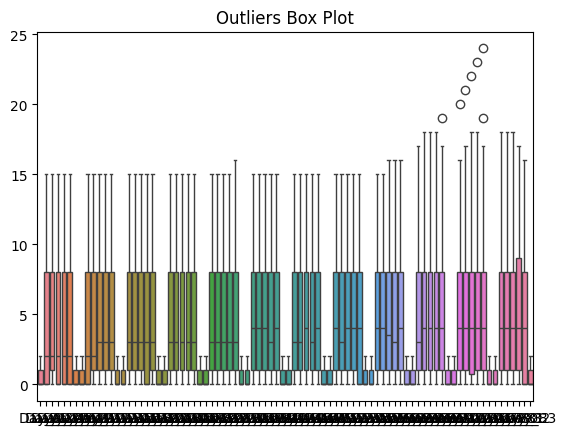

In [17]:
# Checking for outliers using the box plot technique
plt.Figure(figsize=(14,6))
sns.boxplot(data=df_transposed)
plt.title('Outliers Box Plot')
plt.show()

**Inference**: There are minimal outliers detected as shown by the points 

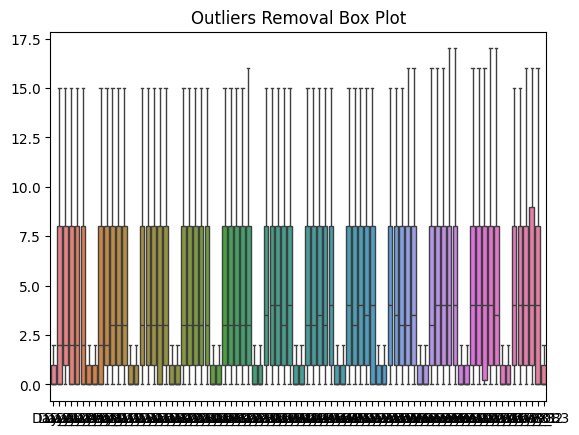

In [18]:
# Removing outliers using the IQR method
Q1 = df_transposed.quantile(0.25)
Q3 = df_transposed.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df_transposed[~((df_transposed < (Q1 - 1.5 * IQR)) | (df_transposed > (Q3 + 1.5 * IQR))).any(axis=1)]

# Confirm outliers removal by plotting a box plot
plt.Figure(figsize=(14,6))
sns.boxplot(data=df_no_outliers)
plt.title('Outliers Removal Box Plot')
plt.show()

Now that our dataset is cleaned and has no outliers, we can proceed to the statistical analysis.

# Statistical Analysis
The Python code below gives the statistical calculations (Mean, Median, Minimum, Maximum and Standard deviation of the number of tasks completed per day by each field agent)

In [19]:
# Calculating Mean, Median, Max, and sd (Individual stats)
AgentStats = pd.DataFrame()  # Create a data-frame to store the statistics
AgentStats['Mean'] = df_no_outliers.mean(axis=1)
AgentStats['Median'] = df_no_outliers.median(axis=1)
AgentStats['Sd'] = df_no_outliers.std(axis=1)
AgentStats['Minimum'] = df_no_outliers.min(axis=1)
AgentStats['Maximum'] = df_no_outliers.max(axis=1)

print(AgentStats)

                Mean  Median        Sd  Minimum  Maximum
Agent 0     6.940476     7.0  3.816108        1       14
Agent 1     6.702381     7.0  3.867628        1       15
Agent 2     7.000000     7.5  4.032996        1       15
Agent 3     0.535714     0.0  0.870486        0        3
Agent 4     7.297619     8.0  4.236331        1       15
...              ...     ...       ...      ...      ...
Agent 1195  0.309524     0.0  0.559177        0        2
Agent 1196  2.083333     2.0  1.716036        0        6
Agent 1197  1.714286     1.0  1.923673        0        8
Agent 1198  7.285714     7.0  4.249937        1       15
Agent 1199  0.595238     0.0  0.879746        0        3

[1198 rows x 5 columns]


**Inferences**
- Looking at the standard deviation of each field agent, it shows a variability in the number of tasks performed per day ranging from 0 to 5 task, with numbers close to 0 indicating low variability whereas those close to 5 indicate a higher variability. 

In [20]:
# Calculating Mean, Median, Max, and sd (Overall stats)
OverallStats = pd.DataFrame()  # Create a data-frame to store the statistics
OverallStats['Mean'] = [df_no_outliers.values.mean()]
OverallStats['Median'] = [np.median(df_no_outliers.values)]
OverallStats['Sd'] = [df_no_outliers.values.std()]
OverallStats['Minimum'] = [df_no_outliers.values.min()]
OverallStats['Maximum'] = [df_no_outliers.values.max()]

print(OverallStats)

       Mean  Median       Sd  Minimum  Maximum
0  3.537672     1.0  4.22351        0       17


**Inferences**
- The average number of tasks completed across all agents is approximately 4 tasks per day.
- The median number of tasks completed is 1 task, thus on most days the agents completed approximately 1 task.
- The minimum and maximum tasks completed on a single day by any agent was 0 and 17 tasks respectively.
- The overall Sd is approximately 4 tasks, which indicates a wider variability in the number of tasks performed across all agents.

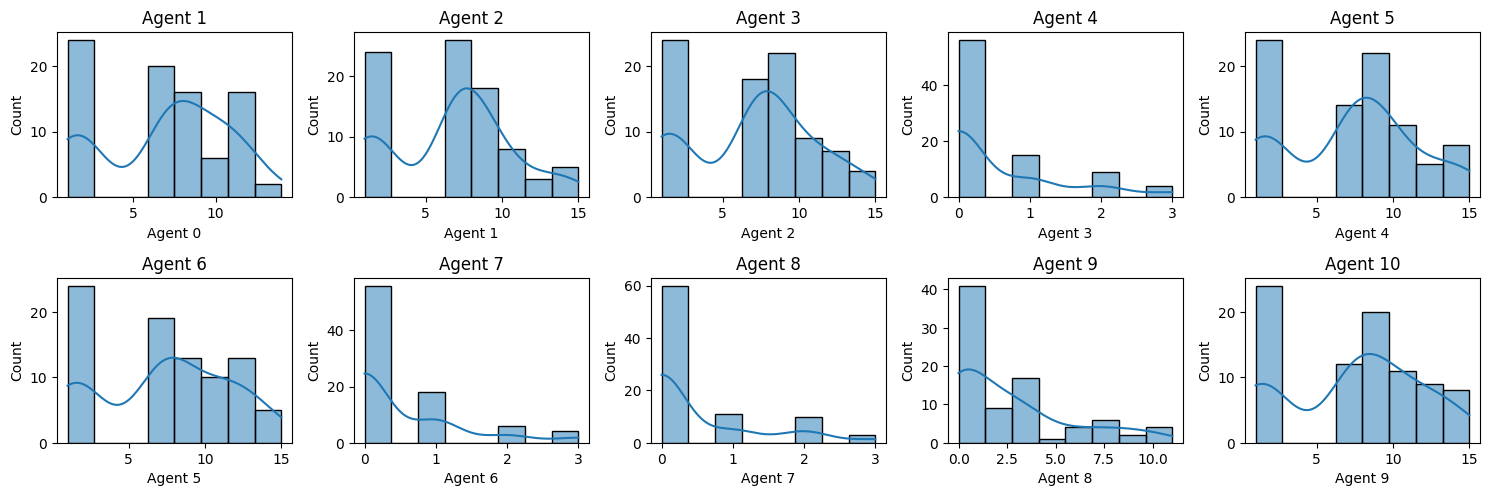

In [21]:
# Checking the data distribution using histograms (each agent)
plt.figure(figsize=(15,12))
NoOfPlots = min(df_no_outliers.shape[0], 10) # limits no. of plots to 10 agents

for i in range(NoOfPlots):
    plt.subplot(5, 5, 1+i)
    sns.histplot(df_no_outliers.iloc[i], kde=True)
    plt.title(f'Agent {i+1}')
    
plt.tight_layout()
plt.show()

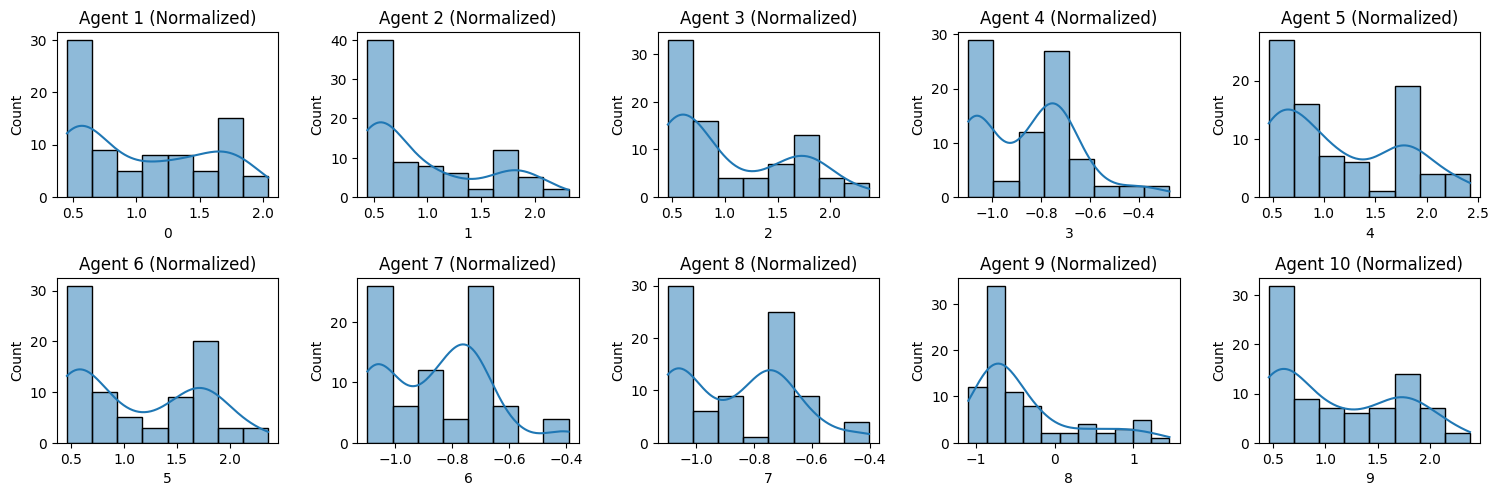

In [22]:
# Normalize the data using StandardScaler and re-plot the histograms
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_no_outliers)
df_normalized = pd.DataFrame(df_normalized, columns = df_no_outliers.columns)

# Plotting the Normalized dataset
plt.figure(figsize=(15,12))
NoOfPlots = min(df_normalized.shape[0], 10) # limits no. of plots to 10 agents

for i in range(NoOfPlots):
    plt.subplot(5, 5, i+1)
    sns.histplot(df_normalized.iloc[i], kde=True)
    plt.title(f'Agent {i+1} (Normalized)')
    
plt.tight_layout()
plt.show()

## Clustering Analysis

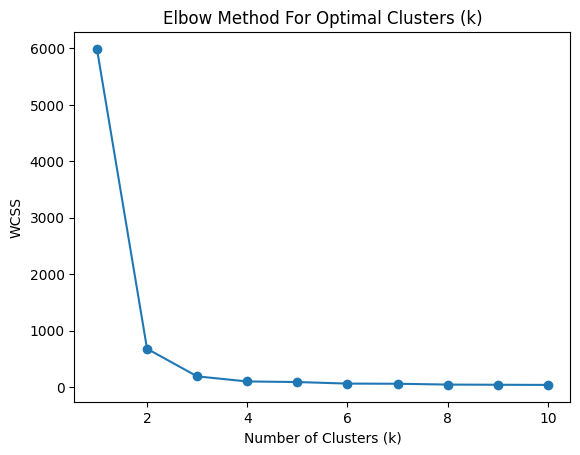

In [23]:
# Clustering the dataset

# Standardize the data
scaler = StandardScaler()
ScaledAgentStats = scaler.fit_transform(AgentStats)

# Using the 'Elbow' method to determine the optimal no. of clusters
wcss = []  # list to store the within cluster sum of squares values

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(ScaledAgentStats)
    wcss.append(kmeans.inertia_)
    
# Plot the 'Elbow' graph
plt.plot(range(1,11), wcss, marker = 'o')
plt.title('Elbow Method For Optimal Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Inference**
- The 'elbow' is around 3 clusters, it suggests that 3 is the optimal number of clusters for this data. Based on this inference, we will have the 3 clusters as; low, moderate and high performers. 

             Mean    Median        Sd   Minimum    Maximum
Cluster                                                   
0        0.522093  0.081594  0.816076  0.000000   3.091082
1        7.151962  7.488347  4.157450  0.997881  14.938559
2        2.951065  2.650754  2.769161  0.000000   9.376884


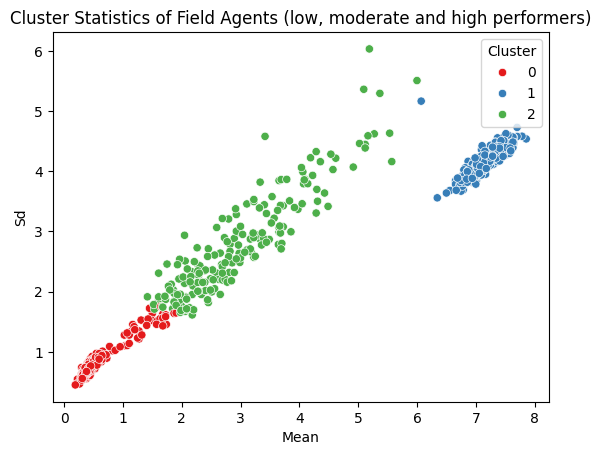

In [24]:
# Assuming k=3 from the 'Elbow' plot
kmeans = KMeans(n_clusters=3, random_state=0).fit(ScaledAgentStats)
AgentStats['Cluster'] = kmeans.labels_

# Analyzing the statistics of each cluster
ClusterStats = AgentStats.groupby('Cluster').mean()
print(ClusterStats)

# Plotting the Cluster Statistics
plt.Figure(figsize=(14, 8))
sns.scatterplot(x='Mean', y='Sd', hue='Cluster', data=AgentStats, palette='Set1')
plt.title('Cluster Statistics of Field Agents (low, moderate and high performers)')
plt.show()

**Inference**

*Low Performers (Red)*
- These Field Agents have low mean values for tasks performed, approximately below 2 tasks.
- They also have a low standard deviation of approximately 1.
- This suggests that the agents in the red zone complete a very low number of tasks.

*Moderate Performers (Green)*
- These Field Agents have mean values ranging from 2 to 6 for tasks performed.
- They also have a wider standard deviation ranging approximately 1 to 5 indicating varying levels of consistency.
- This suggests that the moderate agents in the green zone may have days of high performance in tasks leading to higher standard deviation or have days of low performance in tasks leading to lower standard deviation.

*High Performers (Blue)*
- These Field Agents have high mean values for tasks performed, approximately above 6 tasks.
- They have a moderate standard deviation ranging approximately 2 to 4.
- This suggests that while the agents in the blue zone are highly productive, there is still some variability in the number of tasks they perform.

In [25]:
# Evaluating the quality of the clusters using the Silhouette Score
SilhouetteAvg = silhouette_score(ScaledAgentStats, AgentStats['Cluster'])
print(f'The Silhouette score for the 3 clusters is: {round(SilhouetteAvg, 2)}')

The Silhouette score for the 3 clusters is: 0.83


**Inference**
- The high silhouette score of approximately 0.83 indicates well separation of the clusters and good quality clustering.

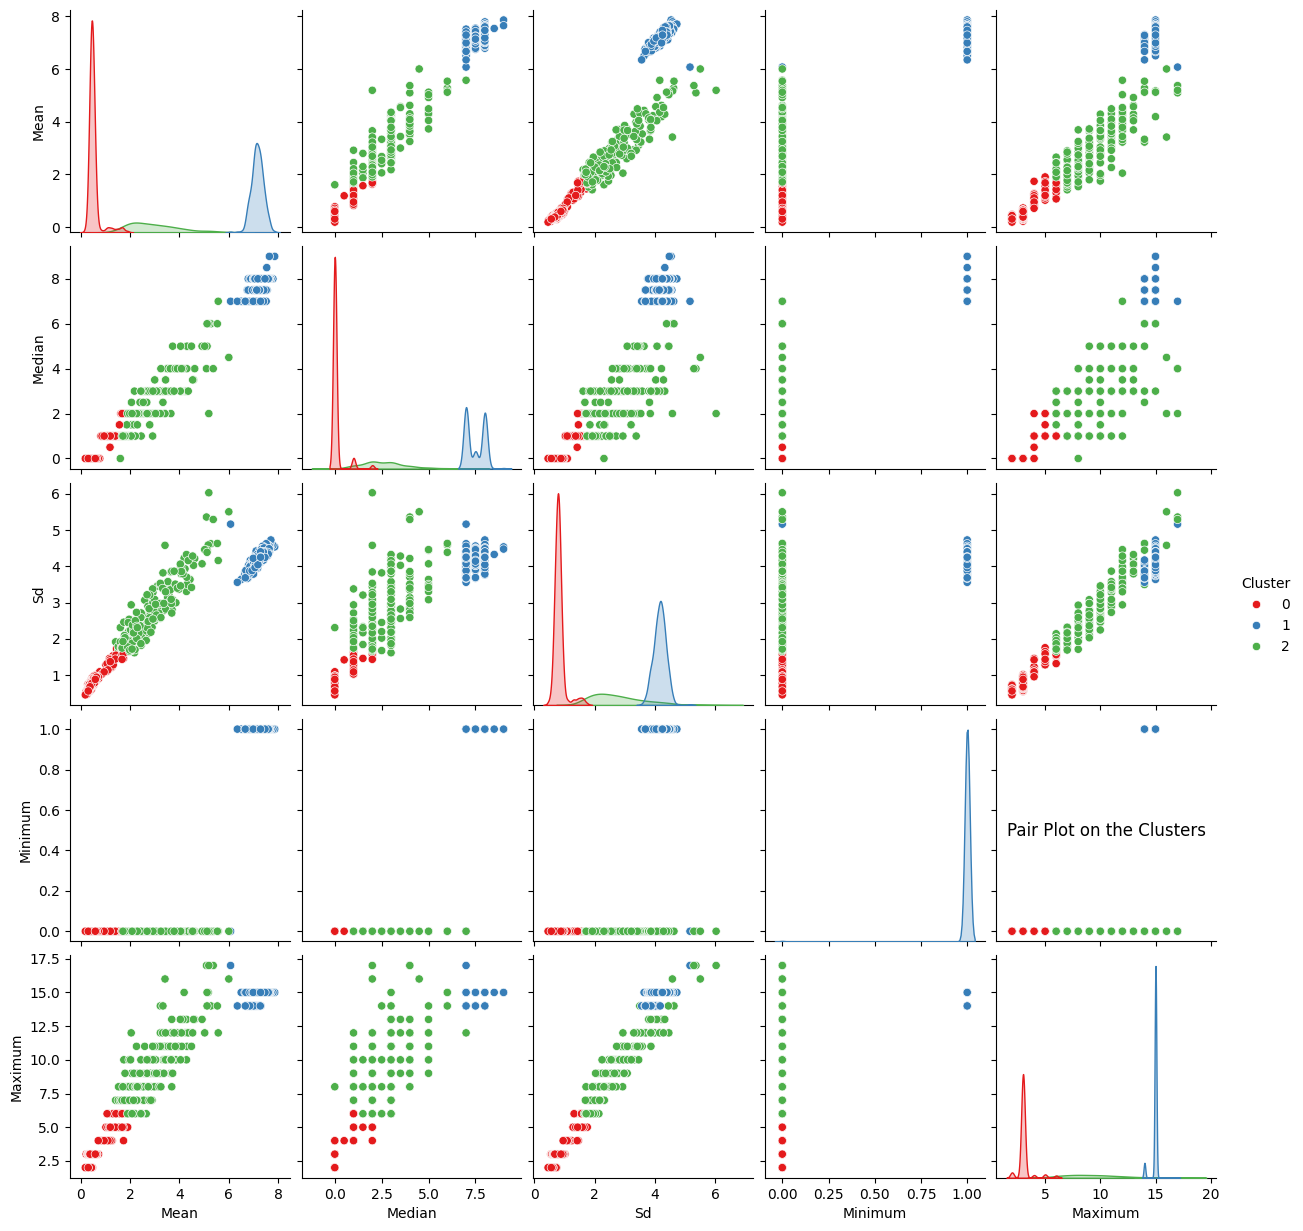

In [26]:
# Visualization with Pair Plots
sns.pairplot(data=AgentStats, hue='Cluster', palette='Set1')
plt.title('Pair Plot on the Clusters', y=1.5)
plt.show()

# Incentive Structure Design

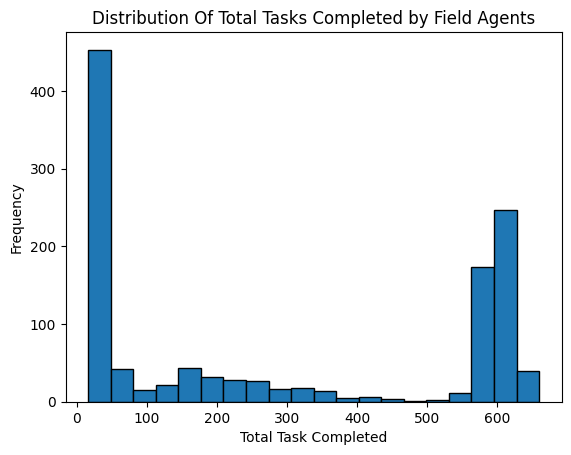

In [27]:
# Calculating total no. of tasks performed by each agent over the 83 days
TotalTasksPerAgent = df_no_outliers.sum(axis=1)
TotalTasksPerAgent.head() 

# Creating a visualization (histogram) to show distribution of total tasks completed
plt.Figure(figsize=(12, 6))
plt.hist(TotalTasksPerAgent, bins=20, edgecolor='black')
plt.xlabel('Total Task Completed')
plt.ylabel('Frequency')
plt.title('Distribution Of Total Tasks Completed by Field Agents')
plt.show()

**Inference**
- There is a major distribution difference between low and high performers, with few field agents being moderate performers.

In [36]:
# Initializing and displaying the compensation
BasePay = 175   # Baseline payment in KSH
print(f'Baseline Payment per Task: KSH {BasePay}')

# Average bonus per task in KSH
AvgBonus = 100
print(f'Average Bonus per Task: KSH {AvgBonus}')

# Total Average compensation per task (in KSH)
AvgCompensation = BasePay + AvgBonus

# Ensuring the Total Avg Compensation per Task is limited to a maximum of KSH 300
if AvgCompensation > 300:
    print('WARNING! The Avg Compensation per Task exceeds the required limit of KSH 300')
else:
    print(f'Total Average Compensation Per Task: KSH {AvgCompensation}')
    
# Apply on actual dataset
def CalcTotalCompensation(TasksCompleted):
    BasePay = 175   # Base payment per task in KSH
    
    if TasksCompleted <= 25:
        bonus = 0   # bonus per task in KSH
    elif 25 < TasksCompleted <= 50:
        bonus = 25
    elif 50 < TasksCompleted <= 75:
        bonus = 75
    else:           # TasksCompleted > 75
        bonus = 125 
        
    # Total compensation per task
    TotalCompensation = BasePay + bonus
    return TotalCompensation

# Total tasks completed by the field agents over the 83-day period
TotalTasksPerAgent

# Merge the total tasks completed by each agent and their corresponding compensation
CompensationPerTask = TotalTasksPerAgent.apply(CalcTotalCompensation)
CompensationSummary = pd.DataFrame({
    'Total Tasks Completed': TotalTasksPerAgent,
    'Total Compensation per Task (KSH)': CompensationPerTask
})

# Display summary on first 10 agents
CompensationSummary.head(10)

Baseline Payment per Task: KSH 175
Average Bonus per Task: KSH 100
Total Average Compensation Per Task: KSH 275


,Total Tasks Completed,Total Compensation per Task (KSH)
Agent 0,583,300
Agent 1,563,300
Agent 2,588,300
Agent 3,45,200
Agent 4,613,300
Agent 5,618,300
Agent 6,42,200
Agent 7,40,200
Agent 8,218,300
Agent 9,625,300


*Inference*

To keep the Compensation per task within the financial limit of KSH 300, the bonuses KSH 0, KSH 50, KSH 100 and KSH 125 per task were used. This aimed to motivate the field agents at different performance levels. The bonus groups are explained as follows:

1. **KSH 0 bonus (0-25 tasks)**
- This level only catered for the base payment of KSH 175 per task for field agents who completed few tasks (0-25 task).
- No bonus assigned was aimed at encouraging them to perform more tasks and hence get an additional compensation.

2. **KSH 50 bonus (26-50 tasks)**
- This level catered for the base payment of KSH 175 and an additional bonus of KSH 50, totaling to KSH 225 compensation per task.
- The KSH 25 bonus aims to motivate the agents in this performance level to move to a more productive performance level.

3. **KSH 100 bonus (51-75 tasks)**
- The compensation for agents in this level totals to KSH 275, inclusive of a significant bonus of KSH 100 per task.
- This range targets field agents who are moderately reproductive, motivating them to aim for higher productivity.

4. **KSH 125 bonus (75+ tasks)**
- The compensation in this level totals to the required financial limit of KSH 300 per task, with a maximum bonus of KSH 125 per task.
- This bonus is designed to reward the top performers, encouraging the maximize their output.

## Financial Evaluation

In [40]:
# Calculating no. of field agents in each bonus group
AgentsCount = pd.cut(CompensationSummary['Total Tasks Completed'],
                     bins=[0, 25, 50, 75, float('inf')],
                     labels=('Ksh 0 bonus', 'Ksh 50 bonus', 'Ksh 100 bonus', 'Ksh 125 bonus')).value_counts()
print(AgentsCount)

Total Tasks Completed
Ksh 125 bonus    704
Ksh 50 bonus     460
Ksh 100 bonus     25
Ksh 0 bonus        9
Name: count, dtype: int64


## Scenario 1

In [52]:
# Calculating the no. of agents in Tiers 1 & 2
AgentsTier1_2 = {
    'Tier 1': 9,    # agents that complete 0-25 tasks
    'Tier 2': 460,   # agents that complete 26-50 tasks
}

# Compensation Per Task in Tier 1 and 2
CompensationTiers1_2 = {
    'Tier 1': 175,    # KSH tasks
    'Tier 2': 225,   # KSH per tasks
}

# Calculating the Avg Compensation in Tiers 1 and 2 
TotalAgentsTier1_2 = sum(AgentsTier1_2.values())
TotalCompensationTiers1_2 = sum(AgentsTier1_2[tier] * CompensationTiers1_2[tier]
                                for tier in AgentsTier1_2)
AvgCompensationTier1_2 = TotalCompensationTiers1_2 / TotalAgentsTier1_2
print(f'Total Number of Agents in Tier 1 and Tier 2: {TotalAgentsTier1_2}')
print(f'Total Compensation per Task for Agents in Tier 1 and Tier 2: KSH {TotalCompensationTiers1_2}')
print(f'Average Compensation per Task in Tiers 1 and 2: KSH {round(AvgCompensationTier1_2,2)}')

Total Number of Agents in Tier 1 and Tier 2: 469
Total Compensation per Task for Agents in Tier 1 and Tier 2: KSH 105075
Average Compensation per Task in Tiers 1 and 2: KSH 224.04


**Inference**

The Average compensation per task in Scenario 1 (Tiers 1 and 2) is Ksh 224.04, which confirms that the average compensation per task for Agents falling in the Tier 1 and Tier 2 categories stays below the Ksh 300 financial limit.

## Scenario 2

In [58]:
# Agents in Tier 3
AgentsTier3 = {
    'Tier 3': 25    # agents that complete 51-75 tasks
}
TotalAgentsTier3 = sum(AgentsTier3.values())

# Compensation per task in Tier 3
CompensationTier3 = {
    'Tier 3': 275
}

# Average Compensation Per Task in Tier 3
TotalCompensationTier3 = sum(CompensationTier3[tier] * AgentsTier3[tier]
                             for tier in AgentsTier3)
AvgCompensationTier3 = TotalCompensationTier3 / TotalAgentsTier3
print(f'Total Number of Agents in Tier 3: {TotalAgentsTier3}')
print(f'Total Compensation per Task for Agents in Tier 3: KSH {TotalCompensationTier3}')
print(f'Average Compensation per Task in Tier 3: KSH {round(AvgCompensationTier3,2)}')

Total Number of Agents in Tier 3: 25
Total Compensation per Task for Agents in Tier 3: KSH 6875
Average Compensation per Task in Tier 3: KSH 275.0


**Inference**

The Average compensation per task in Scenario 2 (Tier 3) is Ksh 275, which confirms that the average compensation per task for Agents falling in the Tier 3 category stays below the Ksh 300 financial limit.

## Scenario 3

In [65]:
# Agents in Tier 4
AgentsTier4 = {
    'Tier 4': 704    # agents that complete 51-75 tasks
}
TotalAgentsTier4 = sum(AgentsTier4.values())

# Compensation per task in Tier 4
CompensationTier4 = {
    'Tier 4': 300
}

# Average Compensation Per Task in Tier 3
TotalCompensationTier4 = sum(CompensationTier4[tier] * AgentsTier4[tier]
                             for tier in AgentsTier4)
AvgCompensationTier4 = TotalCompensationTier4 / TotalAgentsTier4
print(f'Total Number of Agents in Tier 4: {TotalAgentsTier4}')
print(f'Total Compensation per Task for Agents in Tier 4: KSH {TotalCompensationTier4}')
print(f'Average Compensation per Task in Tier 4: KSH {round(AvgCompensationTier4,2)}')

Total Number of Agents in Tier 4: 704
Total Compensation per Task for Agents in Tier 4: KSH 211200
Average Compensation per Task in Tier 4: KSH 300.0


**Inference**

The Average compensation per task in Scenario 3 (Tier 4) is Ksh 300, which confirms that the average compensation per task for Agents falling in the Tier 4 category stays at the Ksh 300 financial limit.

## Visualization for Scenarios 1,2 and 3

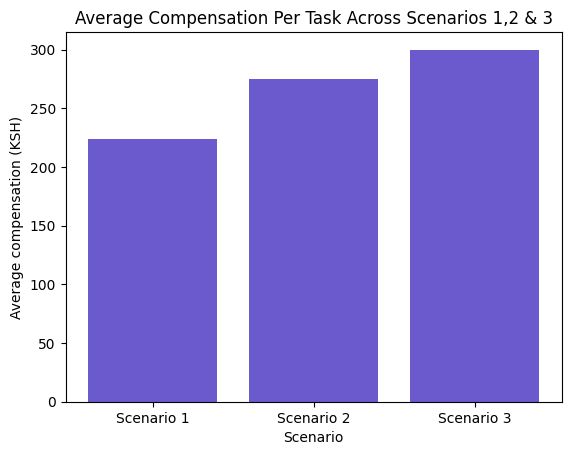

In [64]:
AvgCompensation = {
    'Scenario 1': AvgCompensationTier1_2,
    'Scenario 2': AvgCompensationTier3,
    'Scenario 3': AvgCompensationTier4
}

# Bar Graph representation of avg compensation in each Scenario
plt.Figure(figsize=(12, 6))
plt.bar(AvgCompensation.keys(), AvgCompensation.values(), color='slateblue')
plt.title('Average Compensation Per Task Across Scenarios 1,2 & 3')
plt.xlabel('Scenario')
plt.ylabel('Average compensation (KSH)')
plt.show()

## Total Compensation for All Field Agents

In [66]:
# No. of agents in each tier
AgentsPerTier = {
    'Tier 1': 9,    # KSH per task
    'Tier 2': 460,
    'Tier 3': 25,
    'Tier 4': 704
}

# Compensation per task in each tier
CompensationPerTier = {
    'Tier 1': 175,    # KSH per task
    'Tier 2': 225,
    'Tier 3': 275,
    'Tier 4': 300
}

# Total compensation cost across all field agents
TotalCompensationCost = sum(AgentsPerTier[tier] * CompensationPerTier[tier]
                            for tier in AgentsPerTier)

print(f'Total Compensation Cost: KSH {TotalCompensationCost}')

Total Compensation Cost: KSH 323150


**Inference**

The total compensation cost per task across all agents is approximately Ksh 323,150.

## Conclusion

The incentive structure designed in this project effectively balances motivating field agents to improve their performance and aim for higher levels, while also maintaining the financial constraints of KSH 175 to KSH 300 per task for compensation.
The following conclusions are drawn from this project:

1. **Scenario Analysis**
- *Scenario 1 (Tiers 1 and 2)*: The model remains cost effective and aligns with the financial limits goal even with most field agents falling in these tiers as the average compensations is approximately KSH 224.
- *Scenario 2 (Tier 3)*: The average compensation per task in this tier is KSH 275, which is below the KSH 300 financial limit. This means that the model is still well designed to manage higher levels of performance without exceeding the required budget.
- *Scenario 3 (Tier 4)*: The average compensation per task at this level is KSH 300. Therefore, the financial budget remains under control even when some agents display top performance with more rewarding bonuses.

2. **Compensation Analysis**
- Those in tier 4 had a bigger representation with 704 agents achieving the KSH 125 bonus reward. This concludes that a big proportion of the field agents are being effectively motivated to reach higher levels of performance which aligns with the company's goal of improved performance across all agents.

3. **Total Compensation Cost**
- The total compensation as estimated in this project is KSH 323,150. This cost reflects the financial viability of the incentive structure and it aligns with the company's financial budget. Therefore this incentive structure has proven to be both effective, affordable and sustainable.

## Recommendations
1. Clearly communicate details of the incentives structure to the agents to ensure openness and motivate them to aim for higher bonuses.
2. Monitor performance of the incentive structure by checking dataset updates, adjust the bonuses and targets as needed.
3. Periodically assess the financial viability of the incentive design and perform cost-benefit analysis.
4. Establish a feedback mechanism where agents can share their thoughts on the incentive structure.